# Capstone Project

## Data import and cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import itertools
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df_22 = pd.read_csv('2022_LoL_esports_match_data_from_OraclesElixir_20220324.csv')
df_21 = pd.read_csv('2021_LoL_esports_match_data_from_OraclesElixir_20220324.csv')
df_20 = pd.read_csv('2020_LoL_esports_match_data_from_OraclesElixir_20220324.csv')
df_19 = pd.read_csv('2019_LoL_esports_match_data_from_OraclesElixir_20220324.csv')
df_18 = pd.read_csv('2018_LoL_esports_match_data_from_OraclesElixir_20220324.csv')
df_17 = pd.read_csv('2017_LoL_esports_match_data_from_OraclesElixir_20220324.csv')
df_16 = pd.read_csv('2016_LoL_esports_match_data_from_OraclesElixir_20220324.csv')
df_15 = pd.read_csv('2015_LoL_esports_match_data_from_OraclesElixir_20220324.csv')
df_14 = pd.read_csv('2014_LoL_esports_match_data_from_OraclesElixir_20220324.csv')
frames = [df_22, df_21, df_20, df_19, df_18, df_17, df_16, df_15, df_14]

In [3]:
raw = pd.concat(frames, axis=0, join='outer', ignore_index=True)
leagues = ['LCK', 'LCS', 'LEC', 'NA LCS', 'EU LCS']
data = raw[(raw.league.isin(leagues)) & (raw.position != 'team')].copy()

In [4]:
full = data.copy()

In [5]:
data.isna().sum()

gameid                          0
datacompleteness                0
url                          4030
league                          0
year                            0
split                        1890
playoffs                        0
date                            0
game                            0
patch                        1440
participantid                   0
side                            0
position                        0
playername                      0
playerid                       11
teamname                        0
teamid                        520
champion                        0
ban1                          205
ban2                          120
ban3                          205
ban4                        24445
ban5                        24600
gamelength                      0
result                          0
kills                           0
deaths                          0
assists                         0
teamkills                       0
teamdeaths    

In [6]:
bad_games = data[data.playerid.isna()].gameid.unique()
good_games = data[data.gameid.isin(bad_games) == 0].copy()

good_games.loc[:,'side_pos'] = good_games.loc[:,'side'] + good_games.loc[:,'position']
leagues=good_games[['gameid', 'league']].drop_duplicates().copy()

## Data processing

In [7]:
def score_f(row):
    return (3*row.kills) + (2*row.assists) + (0.02*row['total cs']) + (2*row.firstbloodkill) + (2*(row.triplekills-row.quadrakills)) + (4*(row.quadrakills-row.pentakills)) + (7*row.pentakills) - row.deaths


In [8]:
def unstacker(df, position, side):
    
    if side == 'Blue':
        otherside = 'Red'
    else:
        otherside = 'Blue'
    
    drops = list(df.filter(regex=(f"^(playerid_{side}|score_{side}|max_score_{side})((?!{position}).)*$")).columns)
    drops += list(df.filter(regex=(f"^(playerid|score|max_score)_{otherside}.*")))
    out = df.drop(columns=drops)
    
    own_names = list(out.filter(regex=("^(playerid|score|max_score).*")).columns)
    own_new_names = [x.replace(side+position,'own') for x in own_names]
    own_renamer = dict(zip(own_names, own_new_names))
    out.rename(columns=own_renamer, inplace=True)

    team_names = list(out.filter(regex=(f".*{side}")))
    team_new_names = [x.replace(side, 'team') for x in team_names]
    team_rename = dict(zip(team_names, team_new_names))
    out.rename(columns=team_rename, inplace=True)
    
    enemy_names = list(out.filter(regex=f".*{otherside}"))
    enemy_new_names = [x.replace(otherside, 'enemy') for x in enemy_names]
    enemy_rename = dict(zip(enemy_names, enemy_new_names))
    out.rename(columns=enemy_rename, inplace=True)
    
    out['position'] = position
    
    return out

In [9]:
full['score'] = full.apply(lambda row: score_f(row), axis=1)

In [10]:
aggs = full.groupby(['playerid', 'date'])[['killsat15', 'deathsat15', 'assistsat15', 'total cs', 'score',
                                            'firstbloodkill', 'triplekills', 'quadrakills', 'pentakills', 'gamelength',
                                            'visionscore', 'kills', 'deaths', 'assists', 'damagetochampions', 'dpm']].sum()



In [11]:
cols = list(aggs.columns)
renamer = {}
for col in cols:
    renamer[col] = 'average_'+col
renamer['total cs'] = 'average_cs'

games = full.groupby(['playerid', 'date'])[['playerid']].count()
aggs = pd.merge(aggs, games, left_index=True, right_index=True, how='inner')

renamer['playerid'] = 'total_games'

aggs = aggs.groupby(level=0).cumsum().rename(columns=renamer)
aggs = aggs.groupby(level=0).shift(1)

for i in renamer.values():
    if i != 'total_games':
        aggs[i] = aggs[i]/aggs['total_games']
        
aggs['total_games'].fillna(0, inplace=True)
aggs.fillna(-1, inplace=True)
agg_cols = list(aggs.columns)
aggs.reset_index(inplace=True)
aggs.loc[:,'date'] = pd.to_datetime(aggs.date)

In [12]:
good_games['score'] = good_games.apply(lambda row: score_f(row), axis=1)
good_games.dropna(subset=['score'], inplace=True)

scores = good_games.groupby(['playerid', 'gameid'])[['score']].sum().reset_index()
scores.head()

,playerid,gameid,score
0,oe:player:0015d99e65183977a9e65547b37f1cb,ESPORTSTMNT01_2136240,9.70
1,oe:player:0015d99e65183977a9e65547b37f1cb,ESPORTSTMNT01_2136284,-0.24
2,oe:player:0015d99e65183977a9e65547b37f1cb,ESPORTSTMNT01_2136290,15.56
3,oe:player:0015d99e65183977a9e65547b37f1cb,ESPORTSTMNT01_2137369,-3.34
4,oe:player:0015d99e65183977a9e65547b37f1cb,ESPORTSTMNT01_2137440,12.80


In [13]:
good_games.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,participantid,side,position,playername,playerid,teamname,teamid,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,firstdragon,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,chemtechs,hextechs,dragons (type unknown),elders,opp_elders,firstherald,heralds,opp_heralds,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors,opp_inhibitors,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,gspd,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,side_pos,score
1440,ESPORTSTMNT01_2700815,complete,NaN,LCK,2022,Spring,0,2022-01-12 06:20:03,1,12.01,1,Blue,top,Kingen,oe:player:618a87d272773f68239d8ce5555f39d,DRX,oe:team:101f8589e58c724c1dcd5a9c1555277,Graves,Diana,Caitlyn,Twisted Fate,LeBlanc,Viktor,2195,0,0,5,1,5,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1367,0.5194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,18483.0,505.2301,0.369379,474.5877,645.1298,11.0,0.3007,5.0,0.1367,9.0,35.0,0.9567,13189.0,8435.0,230.5695,0.210996,12875.0,NaN,315.0,270.0,45.0,NaN,NaN,8.6105,3170.0,4619.0,83.0,3223.0,4640.0,89.0,-53.0,-21.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,4763.0,6943.0,127.0,4965.0,7658.0,135.0,-202.0,-715.0,-8.0,0.0,0.0,1.0,0.0,1.0,0.0,Bluetop,3.30
1441,ESPORTSTMNT01_2700815,complete,NaN,LCK,2022,Spring,0,2022-01-12 06:20:03,1,12.01,2,Blue,jng,Pyosik,oe:player:a2357eb17578485c2ba736db36cbc42,DRX,oe:team:101f8589e58c724c1dcd5a9c1555277,Viego,Diana,Caitlyn,Twisted Fate,LeBlanc,Viktor,2195,0,1,3,2,5,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1367,0.5194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3799.0,103.8451,0.075922,640.0456,568.0182,13.0,0.3554,15.0,0.4100,13.0,58.0,1.5854,10792.0,6038.0,165.0478,0.151037,10375.0,NaN,178.0,27.0,151.0,NaN,NaN,4.8656,3075.0,3131.0,63.0,3036.0,3180.0,64.0,39.0,-49.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,5107.0,5355.0,89.0,4867.0,5626.0,104.0,240.0,-271.0,-15.0,1.0,2.0,0.0,1.0,0.0,1.0,Bluejng,7.56
1442,ESPORTSTMNT01_2700815,complete,NaN,LCK,2022,Spring,0,2022-01-12 06:20:03,1,12.01,3,Blue,mid,Zeka,oe:player:f9cd2ef9afea5cda0eb3263a025cec1,DRX,oe:team:101f8589e58c724c1dcd5a9c1555277,Ryze,Diana,Caitlyn,Twisted Fate,LeBlanc,Viktor,2195,0,0,2,0,5,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1367,0.5194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7658.0,209.3303,0.153044,490.6879,271.6811,19.0,0.5194,5.0,0.1367,7.0,39.0,1.0661,14226.0,9472.0,258.9157,0.236936,14075.0,NaN,351.0,304.0,47.0,NaN,NaN,9.5945,3361.0,4914.0,92.0,3326.0,4770.0,91.0,35.0,144.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5589.0,7592.0,144.0,5151.0,7796.0,151.0,438.0,-204.0,-7.0,0.0,0.0,0.0,0.0,0.0,0.0,Bluemid,5.02
1443,ESPORTSTMNT01_2700815,complete,NaN,LCK,2022,Spring,0,2022-01-12 06:20:03,1,12.01,4,Blue,bot,Deft,oe:player:c588a2d07b69ca4ba61c96aebd3f793,DRX,oe:team:101f8589e58c724c1dcd5a9c1555277,Aphelios,Diana,Caitlyn,Twisted Fate,LeBlanc,Viktor,2195,0,3,2,2,5,14,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.1367,0.5194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN

In [14]:
good_games.loc[:,'date'] = pd.to_datetime(good_games.date)
good_games['week'] = good_games.date.dt.isocalendar()['week']
avg_scores = good_games.groupby(['league', 'year', 'week','position', 'playerid'])[['score']].mean().reset_index()
max_scores = avg_scores.groupby(['league', 'year', 'week', 'position'])[['score']].max().reset_index().rename(columns={'score':'max_score'})
max_scores.head(20)

,league,year,week,position,max_score
0,EU LCS,2014,3,bot,46.233333
1,EU LCS,2014,3,jng,27.190000
2,EU LCS,2014,3,mid,39.573333
3,EU LCS,2014,3,sup,27.273333
4,EU LCS,2014,3,top,33.740000
5,EU LCS,2014,4,bot,38.560000
6,EU LCS,2014,4,jng,30.130000
7,EU LCS,2014,4,mid,36.780000
8,EU LCS,2014,4,sup,21.060000
9,EU LCS,2014,4,top,30.160000


In [15]:
good_games = pd.merge(good_games, max_scores, on=['league', 'year', 'week', 'position'], how='left' )

good_games.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,participantid,side,position,playername,playerid,teamname,teamid,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,firstdragon,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,chemtechs,hextechs,dragons (type unknown),elders,opp_elders,firstherald,heralds,opp_heralds,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,turretplates,opp_turretplates,inhibitors,opp_inhibitors,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,gspd,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,side_pos,score,week,max_score
0,ESPORTSTMNT01_2700815,complete,NaN,LCK,2022,Spring,0,2022-01-12 06:20:03,1,12.01,1,Blue,top,Kingen,oe:player:618a87d272773f68239d8ce5555f39d,DRX,oe:team:101f8589e58c724c1dcd5a9c1555277,Graves,Diana,Caitlyn,Twisted Fate,LeBlanc,Viktor,2195,0,0,5,1,5,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1367,0.5194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,18483.0,505.2301,0.369379,474.5877,645.1298,11.0,0.3007,5.0,0.1367,9.0,35.0,0.9567,13189.0,8435.0,230.5695,0.210996,12875.0,NaN,315.0,270.0,45.0,NaN,NaN,8.6105,3170.0,4619.0,83.0,3223.0,4640.0,89.0,-53.0,-21.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,4763.0,6943.0,127.0,4965.0,7658.0,135.0,-202.0,-715.0,-8.0,0.0,0.0,1.0,0.0,1.0,0.0,Bluetop,3.30,2,30.144
1,ESPORTSTMNT01_2700815,complete,NaN,LCK,2022,Spring,0,2022-01-12 06:20:03,1,12.01,2,Blue,jng,Pyosik,oe:player:a2357eb17578485c2ba736db36cbc42,DRX,oe:team:101f8589e58c724c1dcd5a9c1555277,Viego,Diana,Caitlyn,Twisted Fate,LeBlanc,Viktor,2195,0,1,3,2,5,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1367,0.5194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,3799.0,103.8451,0.075922,640.0456,568.0182,13.0,0.3554,15.0,0.4100,13.0,58.0,1.5854,10792.0,6038.0,165.0478,0.151037,10375.0,NaN,178.0,27.0,151.0,NaN,NaN,4.8656,3075.0,3131.0,63.0,3036.0,3180.0,64.0,39.0,-49.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,5107.0,5355.0,89.0,4867.0,5626.0,104.0,240.0,-271.0,-15.0,1.0,2.0,0.0,1.0,0.0,1.0,Bluejng,7.56,2,33.548
2,ESPORTSTMNT01_2700815,complete,NaN,LCK,2022,Spring,0,2022-01-12 06:20:03,1,12.01,3,Blue,mid,Zeka,oe:player:f9cd2ef9afea5cda0eb3263a025cec1,DRX,oe:team:101f8589e58c724c1dcd5a9c1555277,Ryze,Diana,Caitlyn,Twisted Fate,LeBlanc,Viktor,2195,0,0,2,0,5,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1367,0.5194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7658.0,209.3303,0.153044,490.6879,271.6811,19.0,0.5194,5.0,0.1367,7.0,39.0,1.0661,14226.0,9472.0,258.9157,0.236936,14075.0,NaN,351.0,304.0,47.0,NaN,NaN,9.5945,3361.0,4914.0,92.0,3326.0,4770.0,91.0,35.0,144.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5589.0,7592.0,144.0,5151.0,7796.0,151.0,438.0,-204.0,-7.0,0.0,0.0,0.0,0.0,0.0,0.0,Bluemid,5.02,2,34.948
3,ESPORTSTMNT01_2700815,complete,NaN,LCK,2022,Spring,0,2022-01-12 06:20:03,1,12.01,4,Blue,bot,Deft,oe:player:c588a2d07b69ca4ba61c96aebd3f793,DRX,oe:team:101f8589e58c724c1dcd5a9c1555277,Aphelios,Diana,Caitlyn,Twisted Fate,LeBlanc,Viktor,2195,0,3,2,2,5,14,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.1367,0.5194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [16]:
game_data = good_games.pivot(index=['gameid', 'date'], columns='side_pos', values='playerid').reset_index()
#game_data.index.names = ['index']
score_data = good_games.pivot(index=['gameid', 'date'], columns='side_pos', values='max_score').reset_index()
side_pos_list = good_games.side_pos.unique()
names = ['max_score_'+x for x in side_pos_list]
renames = dict(zip(side_pos_list, names))
score_data.rename(columns=renames, inplace=True)
game_data = pd.merge(game_data, score_data, on=['gameid', 'date'], how='inner')
game_data.head(50)

side_pos,gameid,date,Bluebot,Bluejng,Bluemid,Bluesup,Bluetop,Redbot,Redjng,Redmid,Redsup,Redtop,max_score_Bluebot,max_score_Bluejng,max_score_Bluemid,max_score_Bluesup,max_score_Bluetop,max_score_Redbot,max_score_Redjng,max_score_Redmid,max_score_Redsup,max_score_Redtop
0,ESPORTSTMNT01/1031941,2019-01-19 09:53:50,oe:player:9573154ad8bc9459b4c0d940315054f,oe:player:62922f2b370657a966de4d84f5586bf,oe:player:fb6e61b8acb05df17b7e5ad4ae7c800,oe:player:e4e24b8656e4e6a74b939af730b0148,oe:player:b3dae530a02238b0628518ef886e505,oe:player:9405c3aff9112c3c60d03b94792877d,oe:player:b06f165ee2371a61d3be74d413e1e21,oe:player:942180f580887b12bcb04219e0dde84,oe:player:b0ec3df39d61f953e7af0afd8eb8c4a,oe:player:310e4ace014984819dd016f4bd7e763,34.675,34.715,30.635,26.495,31.915,34.675,34.715,30.635,26.495,31.915
1,ESPORTSTMNT01/1031972,2019-01-19 11:38:58,oe:player:a7f8ce07e216556a999d52ab7f06594,oe:player:b06f165ee2371a61d3be74d413e1e21,oe:player:942180f580887b12bcb04219e0dde84,oe:player:c4a5196a4f7e430cf448a76adadb028,oe:player:310e4ace014984819dd016f4bd7e763,oe:player:9573154ad8bc9459b4c0d940315054f,oe:player:62922f2b370657a966de4d84f5586bf,oe:player:fb6e61b8acb05df17b7e5ad4ae7c800,oe:player:e4e24b8656e4e6a74b939af730b0148,oe:player:b3dae530a02238b0628518ef886e505,34.675,34.715,30.635,26.495,31.915,34.675,34.715,30.635,26.495,31.915
2,ESPORTSTMNT01/1032162,2019-01-20 07:36:47,oe:player:c588a2d07b69ca4ba61c96aebd3f793,oe:player:f9fe6d28d5b67bf9ac673b2cc8edf15,oe:player:a442058c6da103458f122260082b7bc,oe:player:45fa65486c55c031328f189912bbe4b,oe:player:9daf04bfd9c8815cc827414f59f45af,oe:player:78081d0b3c01f1f295d52d53744261a,oe:player:e35d06a0430095562086a40a2676d8e,oe:player:1d22c812efd7b8a4244d93c51acc399,oe:player:0923739b522ef9fc94428a92c255531,oe:player:99ce2ea4de279c28bb0315848da8a48,34.675,34.715,30.635,26.495,31.915,34.675,34.715,30.635,26.495,31.915
3,ESPORTSTMNT01/1032172,2019-01-20 08:58:30,oe:player:78081d0b3c01f1f295d52d53744261a,oe:player:e35d06a0430095562086a40a2676d8e,oe:player:1d22c812efd7b8a4244d93c51acc399,oe:player:0923739b522ef9fc94428a92c255531,oe:player:99ce2ea4de279c28bb0315848da8a48,oe:player:c588a2d07b69ca4ba61c96aebd3f793,oe:player:f9fe6d28d5b67bf9ac673b2cc8edf15,oe:player:a2a0d7ab33e23da9a23c463f697f82c,oe:player:45fa65486c55c031328f189912bbe4b,oe:player:9daf04bfd9c8815cc827414f59f45af,34.675,34.715,30.635,26.495,31.915,34.675,34.715,30.635,26.495,31.915
4,ESPORTSTMNT01/1032839,2019-01-23 07:20:06,oe:player:69abfbec6354b4d570ded67d2d59585,oe:player:5dd135d1bcfa7f63c3b7f25425c2a4a,oe:player:30361653a485a9609fb2d3aa073282c,oe:player:b46cf7715e2fe895a9153a650308fff,oe:player:0906d77d4804d5ba6d0c0a7bcf707da,oe:player:c588a2d07b69ca4ba61c96aebd3f793,oe:player:f9fe6d28d5b67bf9ac673b2cc8edf15,oe:player:a442058c6da103458f122260082b7bc,oe:player:45fa65486c55c031328f189912bbe4b,oe:player:9daf04bfd9c8815cc827414f59f45af,35.940,29.285,34.935,25.540,30.035,35.940,29.285,34.935,25.540,30.035
5,ESPORTSTMNT01/1032853,2019-01-23 09:03:46,oe:player:c588a2d07b69ca4ba61c96aebd3f793,oe:player:f9fe6d28d5b67bf9ac673b2cc8edf15,oe:player:a442058c6da103458f122260082b7bc,oe:player:45fa65486c55c031328f189912bbe4b,oe:player:9daf04bfd9c8815cc827414f59f45af,oe:player:479bf0803cf7122f9d77ebf7bfb7576,oe:player:5dd135d1bcfa7f63c3b7f25425c2a4a,oe:player:30361653a485a9609fb2d3aa073282c,oe:player:b46cf7715e2fe895a9153a650308fff,oe:player:0906d77d4804d5ba6d0c0a7bcf707da,35.940,29.285,34.935,25.540,30.035,35.940,29.285,34.935,25.540,30.035
6,ESPORTSTMNT01/1032906,2019-01-23 11:56:54,oe:player:9573154ad8bc9459b4c0d940315054f,oe:player:62922f2b370657a966de4d84f5586bf,oe:player:fb6e61b8acb05df17b7e5ad4ae7c800,oe:player:e4e24b8656e4e6a74b939af730b0148,oe:player:b3dae530a02238b0628518ef886e505,oe:player:887b308d89aa7ff0f3ff21a1c29f588,oe:player:37a18aea52f7509729362a4b97a6ce7,oe:player:1d18fe2cdd43a72d46421ecfe81b599,oe:player:897356954c2cd3d41b221e3f24f99bb,oe:player:06f871352444da0cbc5769be21a42fb,35.940,29.285,34.935,25.540,30.035,35.940,29.285,34.935,25.54

In [17]:
game_data = game_data.reindex(columns = list(game_data.columns)+agg_cols+['score'])
game_data.head()

side_pos,gameid,date,Bluebot,Bluejng,Bluemid,Bluesup,Bluetop,Redbot,Redjng,Redmid,Redsup,Redtop,max_score_Bluebot,max_score_Bluejng,max_score_Bluemid,max_score_Bluesup,max_score_Bluetop,max_score_Redbot,max_score_Redjng,max_score_Redmid,max_score_Redsup,max_score_Redtop,average_killsat15,average_deathsat15,average_assistsat15,average_cs,average_score,average_firstbloodkill,average_triplekills,average_quadrakills,average_pentakills,average_gamelength,average_visionscore,average_kills,average_deaths,average_assists,average_damagetochampions,average_dpm,total_games,score
0,ESPORTSTMNT01/1031941,2019-01-19 09:53:50,oe:player:9573154ad8bc9459b4c0d940315054f,oe:player:62922f2b370657a966de4d84f5586bf,oe:player:fb6e61b8acb05df17b7e5ad4ae7c800,oe:player:e4e24b8656e4e6a74b939af730b0148,oe:player:b3dae530a02238b0628518ef886e505,oe:player:9405c3aff9112c3c60d03b94792877d,oe:player:b06f165ee2371a61d3be74d413e1e21,oe:player:942180f580887b12bcb04219e0dde84,oe:player:b0ec3df39d61f953e7af0afd8eb8c4a,oe:player:310e4ace014984819dd016f4bd7e763,34.675,34.715,30.635,26.495,31.915,34.675,34.715,30.635,26.495,31.915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ESPORTSTMNT01/1031972,2019-01-19 11:38:58,oe:player:a7f8ce07e216556a999d52ab7f06594,oe:player:b06f165ee2371a61d3be74d413e1e21,oe:player:942180f580887b12bcb04219e0dde84,oe:player:c4a5196a4f7e430cf448a76adadb028,oe:player:310e4ace014984819dd016f4bd7e763,oe:player:9573154ad8bc9459b4c0d940315054f,oe:player:62922f2b370657a966de4d84f5586bf,oe:player:fb6e61b8acb05df17b7e5ad4ae7c800,oe:player:e4e24b8656e4e6a74b939af730b0148,oe:player:b3dae530a02238b0628518ef886e505,34.675,34.715,30.635,26.495,31.915,34.675,34.715,30.635,26.495,31.915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ESPORTSTMNT01/1032162,2019-01-20 07:36:47,oe:player:c588a2d07b69ca4ba61c96aebd3f793,oe:player:f9fe6d28d5b67bf9ac673b2cc8edf15,oe:player:a442058c6da103458f122260082b7bc,oe:player:45fa65486c55c031328f189912bbe4b,oe:player:9daf04bfd9c8815cc827414f59f45af,oe:player:78081d0b3c01f1f295d52d53744261a,oe:player:e35d06a0430095562086a40a2676d8e,oe:player:1d22c812efd7b8a4244d93c51acc399,oe:player:0923739b522ef9fc94428a92c255531,oe:player:99ce2ea4de279c28bb0315848da8a48,34.675,34.715,30.635,26.495,31.915,34.675,34.715,30.635,26.495,31.915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ESPORTSTMNT01/1032172,2019-01-20 08:58:30,oe:player:78081d0b3c01f1f295d52d53744261a,oe:player:e35d06a0430095562086a40a2676d8e,oe:player:1d22c812efd7b8a4244d93c51acc399,oe:player:0923739b522ef9fc94428a92c255531,oe:player:99ce2ea4de279c28bb0315848da8a48,oe:player:c588a2d07b69ca4ba61c96aebd3f793,oe:player:f9fe6d28d5b67bf9ac673b2cc8edf15,oe:player:a2a0d7ab33e23da9a23c463f697f82c,oe:player:45fa65486c55c031328f189912bbe4b,oe:player:9daf04bfd9c8815cc827414f59f45af,34.675,34.715,30.635,26.495,31.915,34.675,34.715,30.635,26.495,31.915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ESPORTSTMNT01/1032839,2019-01-23 07:20:06,oe:player:69abfbec6354b4d570ded67d2d59585,oe:player:5dd135d1bcfa7f63c3b7f25425c2a4a,oe:player:30361653a485a9609fb2d3aa073282c,oe:player:b46cf7715e2fe895a9153a650308fff,oe:player:0906d77d4804d5ba6d0c0a7bcf707da,oe:player:c588a2d07b69ca4ba61c96aebd3f793,oe:player:f9fe6d28d5b67bf9ac673b2cc8edf15,oe:player:a442058c6da103458f122260082b7bc,oe:player:45fa65486c55c031328f189912bbe4b,oe:player:9daf04bfd9c8815cc827414f59f45af,35.940,29.285,34.935,25.540,30.035,35.940,29.285,34.935,25.540,30.035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
for col in side_pos_list:
    
    game_data = pd.merge(game_data, aggs, left_on=[col, 'date'], right_on=['playerid', 'date'],
                       how='left', suffixes=('','_'+col )).drop(columns='playerid')
    
    game_data = pd.merge(game_data, scores, left_on=[col, 'gameid'], right_on=['playerid', 'gameid'],
                       how='left', suffixes=('','_'+col )).drop(columns='playerid')

In [19]:
drop_cols = agg_cols + ['score']  
game_data.drop(columns=drop_cols, inplace=True)
names2 = ['playerid_'+x for x in side_pos_list]
renames2 = dict(zip(side_pos_list, names2))
game_data.rename(columns=renames2, inplace=True)

In [20]:
pos = ['top', 'jng', 'mid', 'sup', 'bot']
sides = ['Blue', 'Red']
things = list(itertools.product(pos, sides))
result = pd.DataFrame()
for thing in things:
    temp = unstacker(game_data, thing[0], thing[1])
    result = pd.concat([temp, result], axis=0)

In [21]:
result.head()

,gameid,date,playerid_own,max_score_own,average_killsat15_enemytop,average_deathsat15_enemytop,average_assistsat15_enemytop,average_cs_enemytop,average_score_enemytop,average_firstbloodkill_enemytop,average_triplekills_enemytop,average_quadrakills_enemytop,average_pentakills_enemytop,average_gamelength_enemytop,average_visionscore_enemytop,average_kills_enemytop,average_deaths_enemytop,average_assists_enemytop,average_damagetochampions_enemytop,average_dpm_enemytop,total_games_enemytop,average_killsat15_enemyjng,average_deathsat15_enemyjng,average_assistsat15_enemyjng,average_cs_enemyjng,average_score_enemyjng,average_firstbloodkill_enemyjng,average_triplekills_enemyjng,average_quadrakills_enemyjng,average_pentakills_enemyjng,average_gamelength_enemyjng,average_visionscore_enemyjng,average_kills_enemyjng,average_deaths_enemyjng,average_assists_enemyjng,average_damagetochampions_enemyjng,average_dpm_enemyjng,total_games_enemyjng,average_killsat15_enemymid,average_deathsat15_enemymid,average_assistsat15_enemymid,average_cs_enemymid,average_score_enemymid,average_firstbloodkill_enemymid,average_triplekills_enemymid,average_quadrakills_enemymid,average_pentakills_enemymid,average_gamelength_enemymid,average_visionscore_enemymid,average_kills_enemymid,average_deaths_enemymid,average_assists_enemymid,average_damagetochampions_enemymid,average_dpm_enemymid,total_games_enemymid,average_killsat15_enemybot,average_deathsat15_enemybot,average_assistsat15_enemybot,average_cs_enemybot,average_score_enemybot,average_firstbloodkill_enemybot,average_triplekills_enemybot,average_quadrakills_enemybot,average_pentakills_enemybot,average_gamelength_enemybot,average_visionscore_enemybot,average_kills_enemybot,average_deaths_enemybot,average_assists_enemybot,average_damagetochampions_enemybot,average_dpm_enemybot,total_games_enemybot,average_killsat15_enemysup,average_deathsat15_enemysup,average_assistsat15_enemysup,average_cs_enemysup,average_score_enemysup,average_firstbloodkill_enemysup,average_triplekills_enemysup,average_quadrakills_enemysup,average_pentakills_enemysup,average_gamelength_enemysup,average_visionscore_enemysup,average_kills_enemysup,average_deaths_enemysup,average_assists_enemysup,average_damagetochampions_enemysup,average_dpm_enemysup,total_games_enemysup,average_killsat15_teamtop,average_deathsat15_teamtop,average_assistsat15_teamtop,average_cs_teamtop,average_score_teamtop,average_firstbloodkill_teamtop,average_triplekills_teamtop,average_quadrakills_teamtop,average_pentakills_teamtop,average_gamelength_teamtop,average_visionscore_teamtop,average_kills_teamtop,average_deaths_teamtop,average_assists_teamtop,average_damagetochampions_teamtop,average_dpm_teamtop,total_games_teamtop,average_killsat15_teamjng,average_deathsat15_teamjng,average_assistsat15_teamjng,average_cs_teamjng,average_score_teamjng,average_firstbloodkill_teamjng,average_triplekills_teamjng,average_quadrakills_teamjng,average_pentakills_teamjng,average_gamelength_teamjng,average_visionscore_teamjng,average_kills_teamjng,average_deaths_teamjng,average_assists_teamjng,average_damagetochampions_teamjng,average_dpm_teamjng,total_games_teamjng,average_killsat15_teammid,average_deathsat15_teammid,average_assistsat15_teammid,average_cs_teammid,average_score_teammid,average_firstbloodkill_teammid,average_triplekills_teammid,average_quadrakills_teammid,average_pentakills_teammid,average_gamelength_teammid,average_visionscore_teammid,average_kills_teammid,average_deaths_teammid,average_assists_teammid,average_damagetochampions_teammid,average_dpm_teammid,total_games_teammid,average_killsat15_teambot,average_deathsat15_teambot,average_assistsat15_teambot,average_cs_teambot,average_score_teambot,average_firstbloodkill_teambot,average_triplekills_teambot,average_quadrakills_teambot,average_pentakills_teambot,average_gamelength_teambot,average_visionscore_teambot,average_kills_teambot,average_deaths_teambot,average_assists_teambot,average_damagetochampions_teambot,average_d

## ML

In [22]:
from sklearn import metrics, svm
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split


import lightgbm

In [23]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    rmse = metrics.mean_squared_error(test_labels, predictions, squared=False)
    print('Model Performance')
    print('RMSE: {:0.4f} degrees.'.format(rmse))

In [24]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")

    grad = np.where(y_true<high_score,
                        np.where(residual<0,
                                     -2*10.0*residual,
                                     -2*residual),
                        np.where(residual>0,
                                     -2*10.0*residual,
                                     -2*residual))
    hess = np.where(y_true<high_score,
                        np.where(residual<0,
                                     2*10.0,
                                     2.0),
                        np.where(residual>0,
                                     2*10.0,
                                     2.0))

    return grad, hess

In [25]:
def point_test(model, df, features, verbose=False):
    df.loc[:,'predicted_score_own'] = model.predict(df[features])

    max_pred = df.groupby(['week', 'position', 'playerid_own'])[['predicted_score_own']].mean()
    max_pred = max_pred.groupby(['week', 'position'])[['predicted_score_own']].max()
    max_pred = max_pred.reset_index().rename(columns={'predicted_score_own':'max_predicted_score'})
    df = pd.merge(df, max_pred, on=['week', 'position'], how='left')

    picks = df.groupby(['week','position', 'playerid_own'])[['max_score_own', 'score_own', 
                                                             'predicted_score_own', 'max_predicted_score']].mean().reset_index()
    picks = picks.loc[picks.predicted_score_own == picks.max_predicted_score].copy()
    week = picks.week.unique()
    pos = picks.position.unique()
    combs = itertools.product(week, pos)
    back = pd.DataFrame()
    # to avoid picking multiple players when predicted scores match
    for i in combs:
        temp = picks[(picks.week == i[0]) &  (picks.position == i[1])].copy()
        out = temp.iloc[0,:].to_frame().T
        back = pd.concat([back, out], axis=0)
    
    picks = back

    picks['missed_points'] = picks['max_score_own'].copy() - picks['score_own'].copy()
    picks = picks.groupby('week')[['missed_points', 'score_own']].sum().reset_index()

    out = picks['score_own'][0] * 3
    for i in range(1,7):
        out += picks['score_own'][i] * 2
    out += picks['score_own'][7]*3
    
    if verbose:
        print(out)
        return picks
    else:
        return out


In [26]:
ml_data = pd.merge(result, leagues, on='gameid', how='left')

In [27]:
ml_data.loc[:,'date'] = pd.to_datetime(ml_data.date)
ml_data['year'] = ml_data.date.dt.isocalendar()['year']
ml_data['week'] = ml_data.date.dt.isocalendar()['week']

In [28]:
oe = OrdinalEncoder()
ml_data['position'] = oe.fit_transform(ml_data[['position']])

In [29]:
training = ml_data[ml_data.year < 2022]
testing = ml_data[(ml_data.year == 2022) & (ml_data.league=='LEC')]

In [30]:
targets = list(ml_data.filter(regex=("^score.*")).columns)
unused = list(ml_data.filter(regex=("^max.*|^playerid")).columns)
features = [x for x in ml_data.columns if x not in (targets + unused + ['date', 'gameid', 'league', 'year', 'week'])]

X = training[features]
y = training['score_own']

high_score = y.quantile(q=0.5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=142)

In [31]:
# make new model on new value
gbm0 = lightgbm.LGBMRegressor(random_state=50, num_leaves=31)

gbm0.fit(
    X,
    y
)

point_test(gbm0, testing,features, verbose=False)

C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


2429.96

In [32]:
# make new model on new value
gbm1 = lightgbm.LGBMRegressor(random_state=50, num_leaves=31)
gbm1.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

gbm1.fit(
    X,
    y
)

point_test(gbm1, testing, features, verbose=True)

2433.38


C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,week,missed_points,score_own
0,2,40.280000,121.220000
1,3,10.270000,180.720000
2,4,61.100000,121.490000
3,5,67.470000,95.560000
4,6,32.170000,146.330000
5,7,19.430000,140.620000
6,8,51.260000,111.500000
7,9,54.026667,159.093333


In [41]:
#models indevidual roles
score = 0
for i in range(5):
    training = ml_data[(ml_data.year < 2022) & (ml_data.position == i)]
    testing = ml_data[(ml_data.year == 2022) & (ml_data.league=='LEC') & (ml_data.position == i)]

    X = training[features]
    y = training['score_own']

    high_score = y.quantile(q=0.5)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=142)

    gbm1 = lightgbm.LGBMRegressor(random_state=50, num_leaves=31)
    gbm1.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

    gbm1.fit(
        X,
        y
    )

    score += point_test(gbm1, testing, features, verbose=False)

C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [42]:
score

2225.4199999999996

In [36]:
training.position.unique()

array([0., 3., 2., 1., 4.])

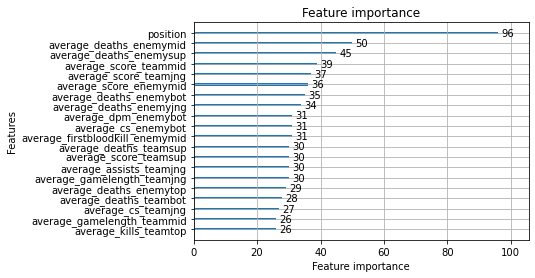

In [35]:
lightgbm.plot_importance(gbm1, max_num_features=20)
plt.show()

## Keras

In [42]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

targets = list(ml_data.filter(regex=("^score.*")).columns)
unused = list(ml_data.filter(regex=("^max.*|^playerid")).columns)
features = [x for x in ml_data.columns if x not in (targets + unused + ['date', 'gameid', 'league', 'year', 'week'])]

X = training[features]
y = training['score_own']

early_stopping_monitor = EarlyStopping(patience=2)



In [36]:
model = Sequential()

model.add(Dense(200, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, validation_split=0.3)

1737/1737 [==============================] - 86s 49ms/step - loss: 229346.7500 - val_loss: 1676.4893


In [37]:
point_test(model, testing, features, verbose=True)

1702.72


C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,week,missed_points,score_own
0,2,71.966667,89.533333
1,3,147.080000,43.910000
2,4,81.240000,101.350000
3,5,73.190000,89.840000
4,6,13.200000,165.300000
5,7,53.700000,106.350000
6,8,76.590000,86.170000
7,9,130.360000,82.760000


In [45]:
model = Sequential()

model.add(Dense(50, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, validation_split=0.3, callbacks=[early_stopping_monitor])

point_test(model, testing, features, verbose=True)

1737/1737 [==============================] - 85s 49ms/step - loss: 20971.1660 - val_loss: 1228.2440


In [46]:
point_test(model, testing, features, verbose=True)

2192.82


C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,week,missed_points,score_own
0,2,30.786667,130.713333
1,3,92.210000,98.780000
2,4,0.000000,182.590000
3,5,38.900000,124.130000
4,6,33.340000,145.160000
5,7,48.490000,111.560000
6,8,28.550000,134.210000
7,9,143.846667,69.273333


In [47]:
model = Sequential()

model.add(Dense(50, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, validation_split=0.3, callbacks=[early_stopping_monitor])

point_test(model, testing, features, verbose=True)

1737/1737 [==============================] - 85s 49ms/step - loss: 5098.0986 - val_loss: 338.9348
2132.2


C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,week,missed_points,score_own
0,2,24.606667,136.893333
1,3,0.000000,190.990000
2,4,129.960000,52.630000
3,5,65.790000,97.240000
4,6,111.180000,67.320000
5,7,15.750000,144.300000
6,8,76.590000,86.170000
7,9,65.046667,148.073333


In [48]:
model = Sequential()

model.add(Dense(100, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, validation_split=0.3, callbacks=[early_stopping_monitor])

point_test(model, testing, features, verbose=True)

1737/1737 [==============================] - 88s 50ms/step - loss: 6713.2534 - val_loss: 453.0989
1853.3000000000002


C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,week,missed_points,score_own
0,2,56.946667,104.553333
1,3,147.080000,43.910000
2,4,81.240000,101.350000
3,5,22.980000,140.050000
4,6,54.310000,124.190000
5,7,53.700000,106.350000
6,8,42.690000,120.070000
7,9,123.853333,89.266667


In [51]:
model = Sequential()

model.add(Dense(100, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, validation_split=0.3, callbacks=[early_stopping_monitor], epochs=30)

point_test(model, testing, features, verbose=True)

Epoch 1/30
1737/1737 [==============================] - 96s 55ms/step - loss: 9968.6045 - val_loss: 179.4790
Epoch 2/30
1737/1737 [==============================] - 5s 3ms/step - loss: 259.4558 - val_loss: 280.3641
Epoch 3/30
1737/1737 [==============================] - 5s 3ms/step - loss: 251.8417 - val_loss: 146.6537
Epoch 4/30
1737/1737 [==============================] - 6s 3ms/step - loss: 215.9476 - val_loss: 142.1711
Epoch 5/30
1737/1737 [==============================] - 5s 3ms/step - loss: 195.7920 - val_loss: 169.4619
Epoch 6/30
1737/1737 [==============================] - 5s 3ms/step - loss: 183.6774 - val_loss: 140.9261
Epoch 7/30
1737/1737 [==============================] - 5s 3ms/step - loss: 179.7611 - val_loss: 142.2814
Epoch 8/30
1737/1737 [==============================] - 5s 3ms/step - loss: 176.9872 - val_loss: 141.2853
2221.86


C:\Users\IsDan\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,week,missed_points,score_own
0,2,30.786667,130.713333
1,3,92.210000,98.780000
2,4,93.990000,88.600000
3,5,66.850000,96.180000
4,6,32.170000,146.330000
5,7,49.310000,110.740000
6,8,51.260000,111.500000
7,9,37.966667,175.153333
